# Labelling

The goal of this notebook is to give each headline an "impact score", indicating its effect on the price

# 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import datetime
import numpy as np
import ast
from scipy.stats import t
import pandas as pd
from pandas.api.indexers import FixedForwardWindowIndexer
import yaml
from tqdm import tqdm
from dotenv import load_dotenv
from collections import Counter
from alpaca_api import AlpacaRequester
import matplotlib.pyplot as plt

tqdm.pandas()

In [2]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

START = str(config['START'])
END = str(config['END'])
PREDICTION_DELTA = config['PREDICTION_DELTA']
OPEN_CUTOFF = config['OPEN_CUTOFF']
CLOSE_CUTOFF = config['CLOSE_CUTOFF']
FWD_WINDOW = config['FWD_WINDOW']
BACK_WINDOW = config['BACK_WINDOW']

In [3]:
articles_df = pd.read_parquet('news/cleaned_news.parquet')

In [4]:
symbols = articles_df.reset_index().symbol.unique()

In [5]:
AR = AlpacaRequester()
calendar: pd.DataFrame = AR.market_calendar(start='2019-12-30',end='2026-01-01')[['date','open','close']]  # type: ignore
calendar['open'] = pd.to_datetime(
    calendar['date'].dt.strftime('%Y-%m-%d') + " " + calendar['open'],
    format='%Y-%m-%d %H:%M'
).dt.tz_localize('America/New_York')
calendar['close'] = pd.to_datetime(
    calendar['date'].dt.strftime('%Y-%m-%d') + " " + calendar['close'],
    format='%Y-%m-%d %H:%M'
).dt.tz_localize('America/New_York')
calendar.rename(columns={'open':'mkt_open','close':'mkt_close'},inplace=True)

# 1. Compute Impact Scores

Given a minute timestamp for a ticker on a day, we compute the impact score as the *standardized cumulative abnormal log returns*, which is given by the following formula:

$$
\mathrm{SCAR}=\frac{\sum_{t=t_0}^{t_0+T}(r_t-\mu_t)}{\sigma_t\sqrt{T+1}}
$$

where:
- $T$ is the length of the forward-looking window over which we're testing for impact
- $r_t=\ln(\mathrm{VW}_t/\mathrm{VW}_{t+1})$ is log returns of VWAP for bar $t$
- $\mu_t$ is the average of $r_t$ over some backwards-looking window up to (not including) time $t$
- $\sigma_t$ is the standard deviation of $r_t$ over that same backwards-looking window

In [6]:
def compute_impact_old(day_bars):
    """
    Takes in a dataframe of 1 minute bars for a single trading day for a single ticker, and outputs 
    a series of "impact scores", which quantifies significant abnormal returns in a short window
    following that timestamp
    """
    # Forward fill missing vwap's with last seen closing price
    vw = day_bars['vw'].fillna(day_bars['c'].ffill())  
    
    # Compute log returns of vwap
    lr = np.log(vw / vw.shift(1))

    # Compute backward looking mean and std
    mu = lr.rolling(window=BACK_WINDOW,closed='left',min_periods=1).mean()
    sigma = lr.rolling(window=BACK_WINDOW,closed='left',min_periods=1).std(ddof=0).clip(lower=1e-6)

    # Abnormal log returns
    lrc = lr - mu

    # Cumulative abnormal log returns
    fwd_win = FixedForwardWindowIndexer(window_size=FWD_WINDOW + 1)
    car = lrc.rolling(window=fwd_win, min_periods=1).sum()

    # Standarized cumulative abnormal log returns
    n_bars = lrc.rolling(window=fwd_win, min_periods=1).count()
    scar = car / (np.sqrt(n_bars) * sigma)
    scar.name = 'impact'

    return scar

It would be nice if our signal was volume-aware. We can improve it with the following formula:

$$
\mathrm{VSCAR}=\frac{\sum_{t=t_0}^{t_0+T}v_t(r_t-\mu_t)}{\sigma_t\sqrt{\sum_{t=t_0}^{t_0+T}v_t^2}}
$$

where $v_t$ is the volume for minute bar $t$

In [7]:
def compute_impact(day_bars):
    """
    Takes in a dataframe of 1 minute bars for a single trading day for a single ticker, and outputs 
    a series of 'impact scores', quantifying significant abnormal returns in a short window,
    volume-weighted, and standardized for cross-stock comparison.
    """
    vw = day_bars['vw'].fillna(day_bars['c'].ffill())
    lr = np.log(vw / vw.shift(1))
    mu = lr.rolling(window=BACK_WINDOW, closed='left', min_periods=1).mean()
    sigma = lr.rolling(window=BACK_WINDOW, closed='left', min_periods=1).std(ddof=0).clip(lower=1e-6)
    lrc = lr - mu

    # volume
    v = day_bars['v'].fillna(0).astype(float)

    # Forward window for volume-weighted cumulative abnormal returns
    fwd_win = FixedForwardWindowIndexer(window_size=FWD_WINDOW + 1)
    # Numerator: sum v_t * lrc_t over the window
    vcar = (v * lrc).rolling(window=fwd_win, min_periods=1).sum()
    # Denominator: sigma * sqrt(sum v_t^2) over the window
    v2_sum = (v**2).rolling(window=fwd_win, min_periods=1).sum()

    vscar = vcar / (sigma * np.sqrt(v2_sum))
    vscar.name = 'impact'
    return vscar


In [8]:
from pathlib import Path

save_new = "bars/{}_new.parquet"

def compute_impacts(tkr,show_progress=True,rerun=False):
    if not rerun and Path(save_new.format(tkr)).exists():
        return pd.read_parquet(f"bars/{tkr}_new.parquet")

    # Get bars
    bars = pd.read_parquet(f'bars/{tkr}.parquet')
    bars.set_index('t',inplace=True)

    # We want to re-index to all minutes during trading day

    # First get all minutes during trading day
    oc = bars.reset_index()[['mkt_open','mkt_close']].drop_duplicates(keep='first')
    durations = ((oc['mkt_close'] - oc['mkt_open']) / pd.Timedelta(minutes=1)).astype(int)
    start_times = np.repeat(oc['mkt_open'].values, durations)
    minute_offsets = np.concatenate([np.arange(d) for d in durations])
    all_minutes = start_times + np.array([np.timedelta64(m, 'm') for m in minute_offsets])
    all_minutes = pd.Series(all_minutes).dt.tz_localize('UTC').dt.tz_convert('America/New_York')
    all_minutes.name = 't'

    # Then re-index
    bars = bars.reindex(all_minutes).reset_index()

    # Add date to rows created by re-indexing (which have all NaN entries except 
    # for `t`, # which is the index), so we can group by date later
    bars['date'] = bars['t'].dt.tz_convert(None).dt.normalize()

    # Make impact scores
    if show_progress:
        impact = bars.groupby('date').progress_apply(compute_impact,include_groups=False)
    else:
        impact = bars.groupby('date').apply(compute_impact,include_groups=False)
    bars['impact'] = impact.reset_index(drop=False).set_index('level_1')['impact']

    # Get old impact scores
    if show_progress:
        impact = bars.groupby('date').progress_apply(compute_impact_old,include_groups=False)
    else:
        impact = bars.groupby('date').apply(compute_impact_old,include_groups=False)
    bars['impact_old'] = impact.reset_index(drop=False).set_index('level_1')['impact']

    bars.to_parquet(save_new.format(tkr))

    return bars

In [9]:
articles_df['t'] = articles_df['created_at'].dt.floor('min')
articles_df = pd.concat([
    group.merge(compute_impacts(tkr,show_progress=False)[['t','impact','impact_old']], how='left', on='t').assign(symbol=tkr)
    for tkr, group in tqdm(articles_df.groupby('symbol'),smoothing=0)
])

100%|██████████| 100/100 [00:01<00:00, 58.89it/s]


In [10]:
articles_df['impact_mag'] = np.abs(articles_df['impact'])
articles_df['impact_old_mag'] = np.abs(articles_df['impact_old'])

In [11]:
articles_df.to_parquet('news/labelled_news.parquet')
articles_df

,created_at,updated_at,headline,symbol,t,impact,impact_old,impact_mag,impact_old_mag
0,2020-01-14 11:37:55-05:00,2020-01-14 11:37:55-05:00,American Airlines Anticipates That Resumption ...,AAL,2020-01-14 11:37:00-05:00,-1.929170,-1.500926,1.929170,1.500926
1,2020-01-14 15:45:57-05:00,2020-01-14 15:45:57-05:00,American Airlines Delays Starting 737 MAX Serv...,AAL,2020-01-14 15:45:00-05:00,-0.985275,-0.885881,0.985275,0.885881
2,2020-01-16 15:35:54-05:00,2020-01-16 15:35:54-05:00,5 Reasons To Invest In Spirit Airlines Stock,AAL,2020-01-16 15:35:00-05:00,1.605030,1.049058,1.605030,1.049058
3,2020-01-22 13:50:38-05:00,2020-01-22 13:50:38-05:00,Q4 Earnings Preview For American Airlines Group,AAL,2020-01-22 13:50:00-05:00,1.096184,1.105646,1.096184,1.105646
4,2020-01-23 11:14:16-05:00,2020-01-23 11:14:16-05:00,PreMarket Prep Recap: Coronavirus Concerns Res...,AAL,2020-01-23 11:14:00-05:00,-0.176862,-0.260660,0.176862,0.260660
...,...,...,...,...,...,...,...,...,...
401,2025-06-09 12:04:38-04:00,2025-06-09 12:04:39-04:00,Oracle To Rally Around 15%? Here Are 10 Top An...,ZS,2025-06-09 12:04:00-04:00,0.174626,-0.064183,0.174626,0.064183
402,2025-06-11 09:46:18-04:00,2025-06-11 09:46:18-04:00,Cantor Fitzgerald Maintains Overweight on Zsca...,ZS,2025-06-11 09:46:00-04:00,-0.964359,-0.787446,0.964359,0.787446
403,2025-06-24 15:12:46-04:00,2025-06-24 15:12:46-04:00,3 Cybersecurity ETFs To Gain Ground As Threats...,ZS,2025-06-24 15:12:00-04:00,-0.125792,0.476880,0.125792,0.476880
404,2025-06-27 10:00:59-04:00,2025-06-27 10:00:59-04:00,47 Analysts Have This To Say About Zscaler,ZS,2025-06-27 10:00:00-04:00,0.469322,0.317546,0.469322,0.317546


# 2. Evaluate Impact Scores

## 2.1. Distribution Analysis

Now that we have labelled articles with impact scores, let's see how these scores do. To start, let's look at a plot of distributions of scores

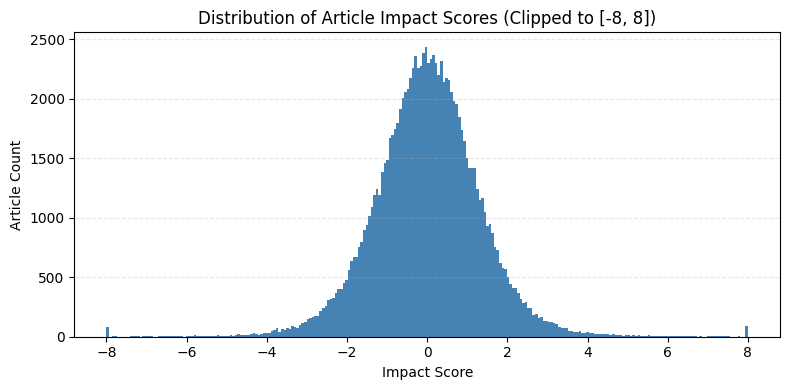

In [12]:
plt.figure(figsize=(8, 4))
plt.hist(articles_df['impact'].clip(-8, 8), bins=250, color='steelblue')
plt.title('Distribution of Article Impact Scores (Clipped to [-8, 8])')
plt.xlabel('Impact Score')
plt.ylabel('Article Count')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Let's plot the 90% percentile highest-impact articles by the time of day they occur

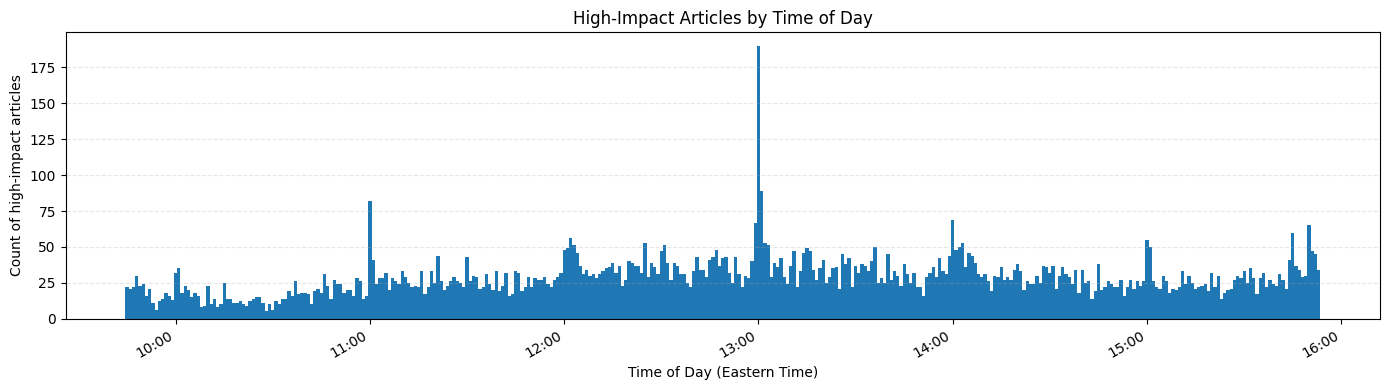

In [13]:
cutoff = articles_df['impact_mag'].quantile(0.9)
hi = articles_df[articles_df['impact_mag'] >= cutoff][['t']].copy()
hi['time_of_day'] = hi['t'].dt.time 
hi['min_of_day'] = hi['t'].dt.hour * 60 + hi['t'].dt.minute
counts = hi.groupby('min_of_day').size()
times_dt = [pd.to_datetime('2000-01-01')+ pd.Timedelta(minutes=m) for m in counts.index]

plt.figure(figsize=(14, 4))
plt.bar(times_dt, counts.values,width=0.0007) 

plt.title('High-Impact Articles by Time of Day')
plt.xlabel('Time of Day (Eastern Time)')
plt.ylabel('Count of high-impact articles')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

Let's also plot a histogram of all the impact scores

100%|██████████| 100/100 [00:04<00:00, 20.95it/s]


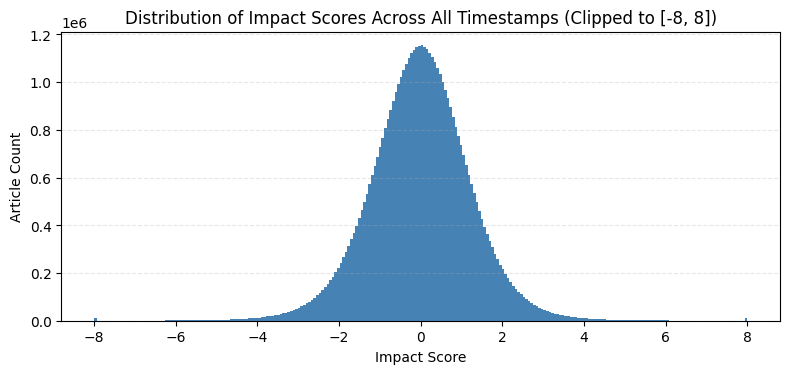

In [14]:
all_impacts = pd.concat([
    pd.read_parquet(save_new.format(symbol))
      .query('(@OPEN_CUTOFF <= (t - mkt_open).dt.total_seconds()/60) & ((mkt_close - t).dt.total_seconds()/60 > @CLOSE_CUTOFF)')
      .set_index('t')['impact']
    for symbol in tqdm(symbols)
])

plt.figure(figsize=(8, 4))
plt.hist(all_impacts.clip(-8, 8), bins=250, color='steelblue')
plt.title('Distribution of Impact Scores Across All Timestamps (Clipped to [-8, 8])')
plt.xlabel('Impact Score')
plt.ylabel('Article Count')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

We can fit a t-distribution

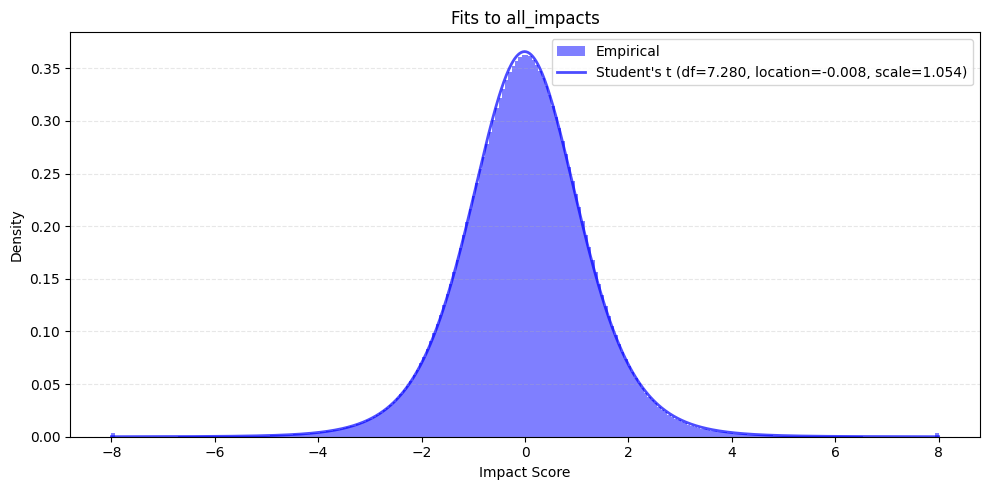

In [15]:
data = all_impacts.clip(-8, 8).dropna().values
sample = all_impacts.sample(n=1_000_000,random_state=42).clip(-8,8).dropna()

df_t, loc_t, scale_t = t.fit(sample)
x = np.linspace(data.min(), data.max(), 1000)

plt.figure(figsize=(10, 5))

plt.hist(data, bins=250, density=True, color='blue', alpha=0.5, label='Empirical')
plt.plot(x, t.pdf(x, df_t, loc_t, scale_t), 'b-', alpha=0.7, lw=2, label=f"Student's t (df={df_t:.3f}, location={loc_t:.3f}, scale={scale_t:.3f})")

plt.title('Fits to all_impacts')
plt.xlabel('Impact Score')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## 2.2. Manual Inspection

Next we'll look at some randomly-chosen individual headlines with high (in magnitude) scores.

In [16]:
def print_row(row):
    tkr = row['symbol']
    date = row['created_at'].tz_localize(None).normalize()
    df = compute_impacts(tkr).set_index('date').loc[date].reset_index(drop=True).set_index('t')
    ax = df.c.ffill().plot()

    ax.axvline(row['created_at'], color='red',alpha=0.7)

    print('ticker:',tkr)
    print('ts:',row['created_at'])
    print('headline:',row['headline'])
    print('score:',row['impact'])
    plt.title(f'{tkr} | {date.date()}')
    plt.show()

High scores:

In [17]:
hi = articles_df[articles_df['impact'] >= 2].sample(n=15,random_state=42)
lo = articles_df[articles_df['impact'] <= -2].sample(n=15,random_state=42)

ticker: MA
ts: 2022-04-18 12:42:59-04:00
headline: B of A Securities Maintains Buy on Mastercard, Lowers Price Target to $402
score: 2.6863872712549695


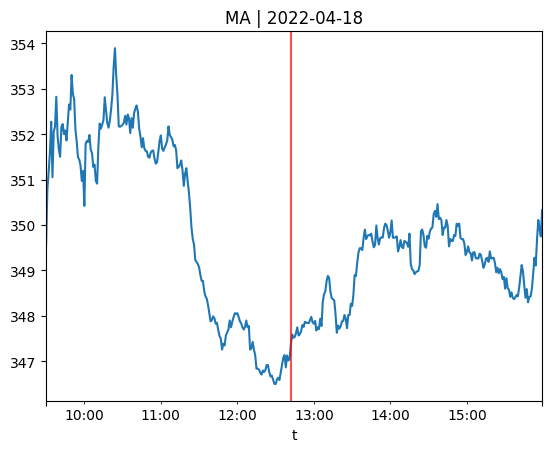

ticker: DAL
ts: 2021-12-14 12:58:49-05:00
headline: Congressional Testimony Of US Airlines Shows Airlines Planning To Hire More, Defend Gov't. COVID-19 Rescue
score: 2.333726692684988


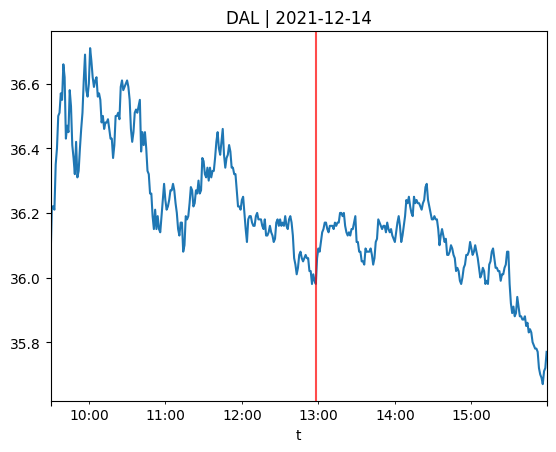

ticker: SQ
ts: 2023-03-23 13:34:04-04:00
headline: Block Issues Response To Short Seller Report
score: 2.3418329827409488


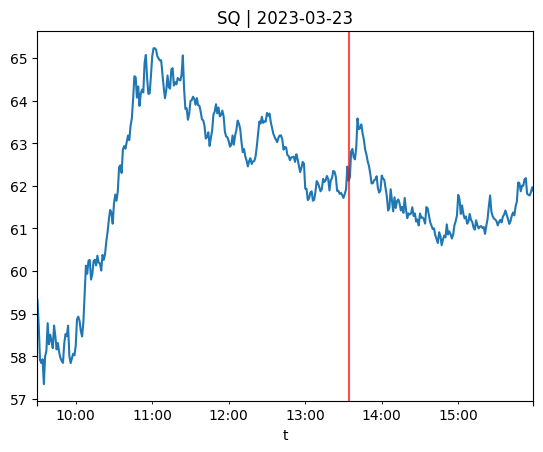

ticker: MRK
ts: 2023-08-25 13:49:45-04:00
headline: Pharma Giants Unite Against Drug Price Negotiation: AstraZeneca Latest To Challenge The Government
score: 2.450588761925596


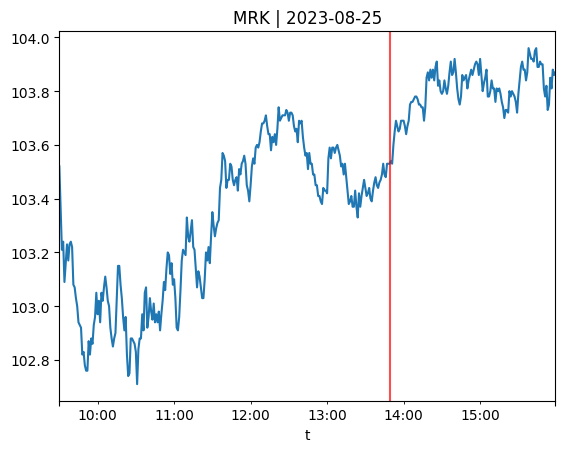

ticker: NFLX
ts: 2024-10-18 13:36:05-04:00
headline: Oppenheimer Maintains Outperform on Netflix, Raises Price Target to $825
score: 3.617824319639875


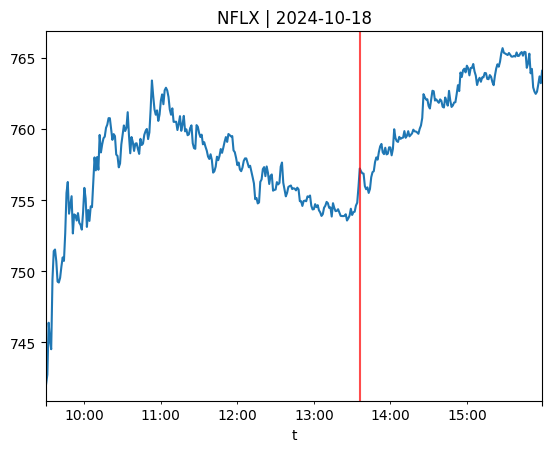

ticker: AAPL
ts: 2022-06-28 12:22:11-04:00
headline: TF International Securities Analyst Tweets 'My latest survey indicates that Apple's own iPhone 5G modem chip development may have failed, so Qualcomm will remain exclusive supplier for 5G chips of 2H23 new iPhones...'
score: 2.174606362053399


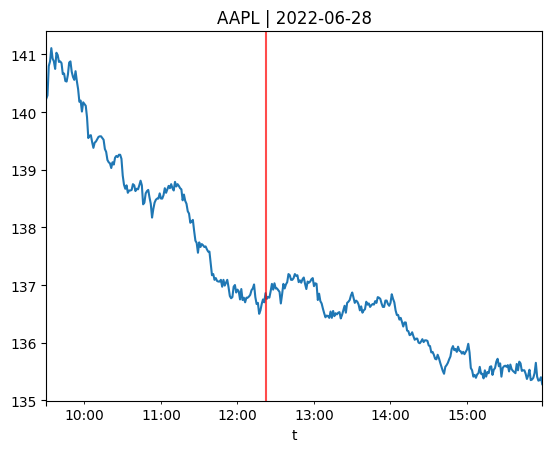

ticker: GOOGL
ts: 2022-02-02 14:30:04-05:00
headline: Mid-Afternoon Market Update: Dow Surges Over 150 Points; PayPal Shares Slide On Earnings Miss
score: 2.1571147612227723


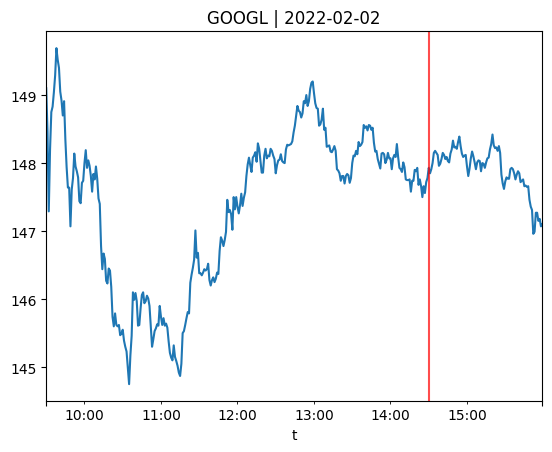

ticker: GOOGL
ts: 2020-12-29 10:15:25-05:00
headline: Google, Facebook Dispute States' Claims, Say Their Contract Was Above Board
score: 2.383138769338155


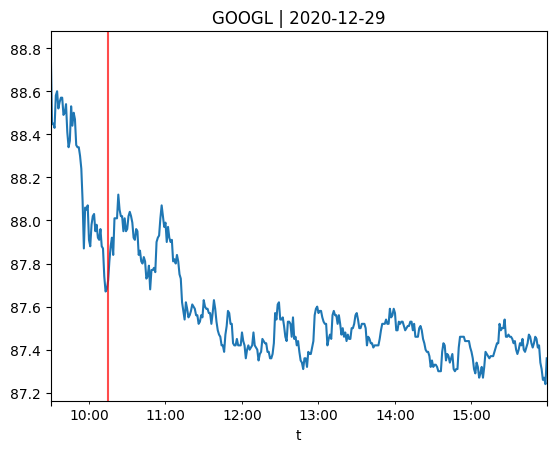

ticker: LLY
ts: 2021-01-19 10:50:16-05:00
headline: Why Aclaris, Tenax, Gritstone, Merus, Minerva And Celyad Are Rallying Today
score: 2.511090956933145


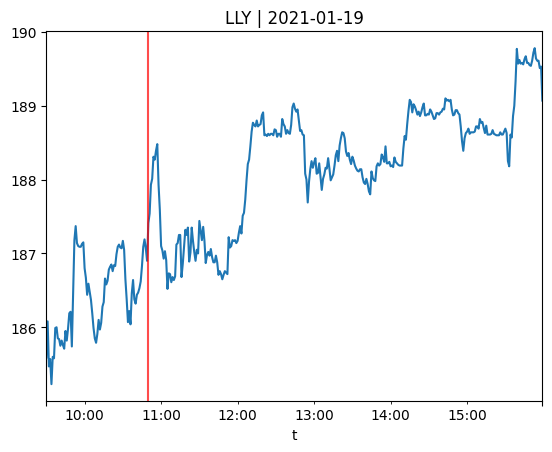

ticker: AMZN
ts: 2020-07-24 11:21:56-04:00
headline: Should We Maintain High Expectations For FAANG?
score: 2.2598064629639976


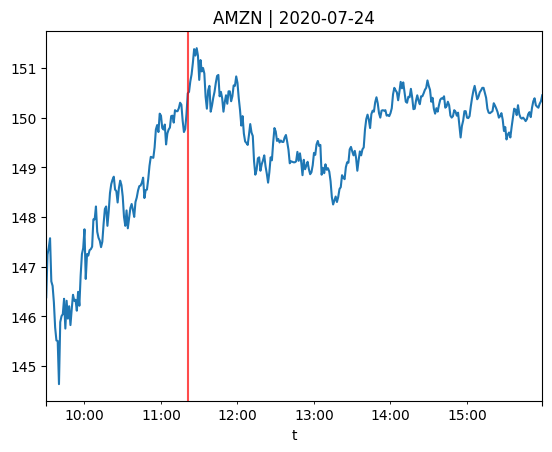

ticker: C
ts: 2024-01-12 12:44:13-05:00
headline: Citi CFO Says Headcount Reductions Will Generate $2B-$2.5B In Savings Over The Medium Term; Company Expects To Do A Modest Number Of Share Buybacks In Q1
score: 2.606896146745705


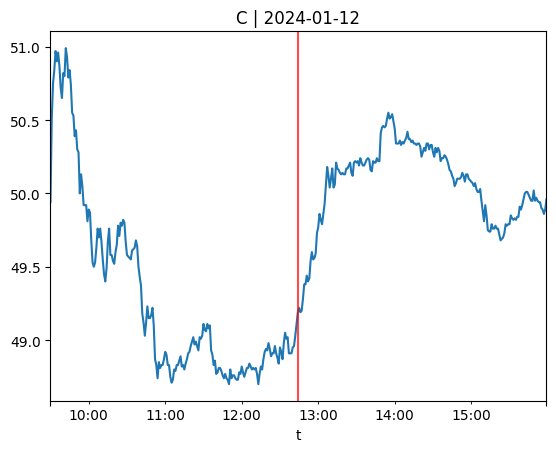

ticker: META
ts: 2021-05-11 11:17:55-04:00
headline: Entering Final 'Run into Earnings' Wave...
score: 4.520862687649935


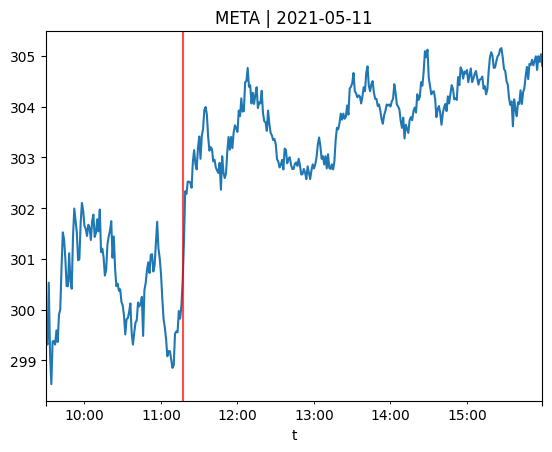

ticker: LMT
ts: 2022-04-05 10:37:30-04:00
headline: MDA Partners With Lockheed Martin, General Motors On Lunar Rover Development
score: 2.1845145763396303


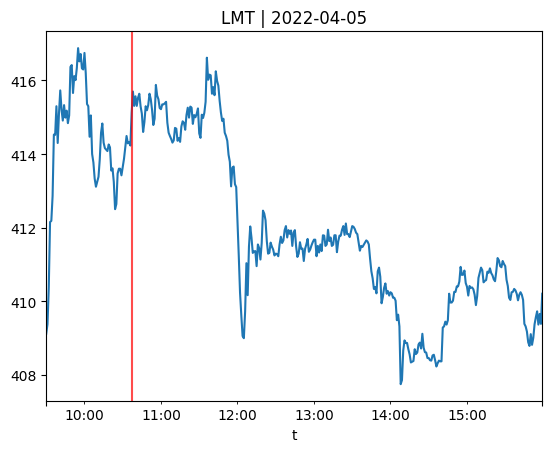

ticker: TGT
ts: 2022-04-26 12:27:07-04:00
headline: On CNBC: Chevy Chase Trust's Amy Raskin Trimmed Positions In EOG Resources, Estee Lauder, Added To Position In Target
score: 2.006616513500686


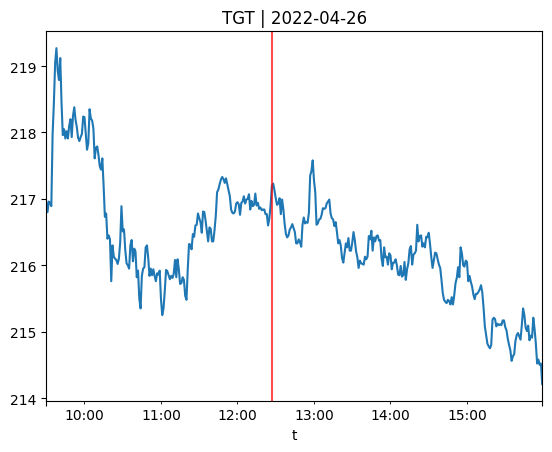

ticker: WFC
ts: 2021-03-30 11:08:11-04:00
headline: Wells Fargo Shares Spike Higher Following Statement Bank Did Not Incur Losses Related To Closing Out Hedge Fund Exposure
score: 3.2219334871037058


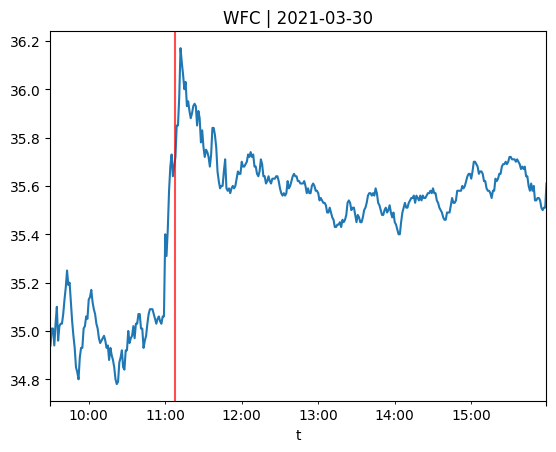

In [18]:
for _,row in hi.iterrows():
    print_row(row)

ticker: UAL
ts: 2020-01-31 12:32:22-05:00
headline: US Association Of Flight Attendants Alert Suggests Communications Works Of America Labor Union Has Called For 'Clear Direction' From US Gov't. To Airlines To 'Pull Down' All Travel To China Until Coronavirus Contained
score: -2.256019919154277


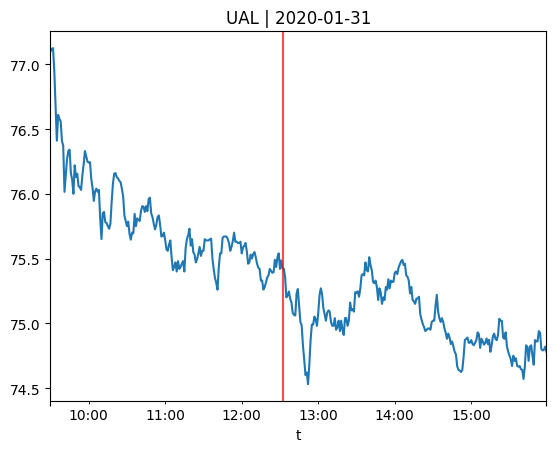

ticker: GM
ts: 2021-09-16 13:00:33-04:00
headline: CNBC Halftime Report Final Trades: Los Vegas Sands, Coinbase, General Motors, Cleveland Cliffs
score: -2.7760246573351925


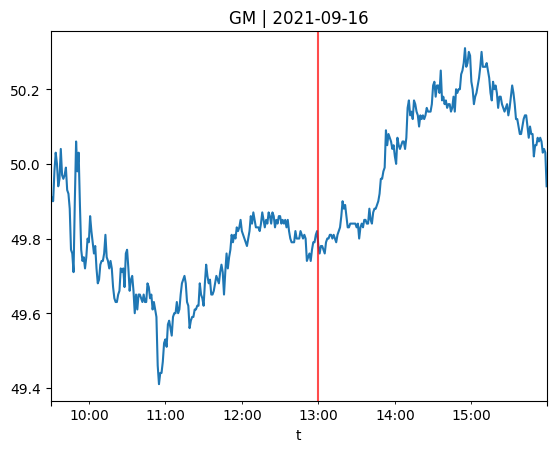

ticker: META
ts: 2021-10-05 12:51:40-04:00
headline: Bipartisan Senate Group Backs Facebook Research Subpoenas
score: -3.2639130154727587


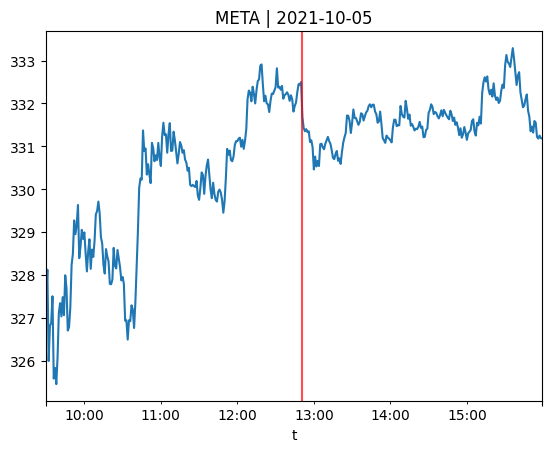

ticker: LMT
ts: 2023-04-18 13:29:12-04:00
headline: What's Going On With Lockheed Martin Shares Today?
score: -2.5915642180420826


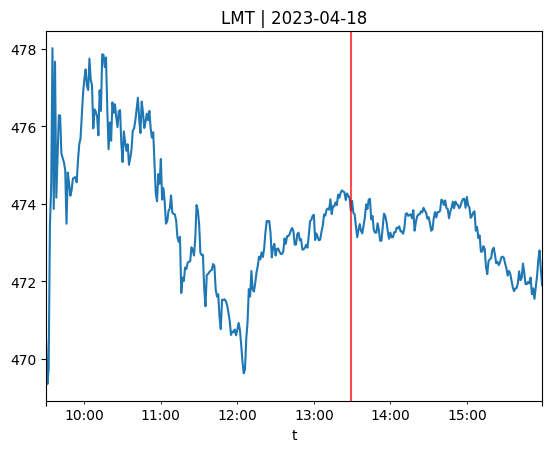

ticker: TSLA
ts: 2020-06-30 11:47:03-04:00
headline: Tesla's Latest Over-The-Air Update For Full Self-Driving Adds Green Light Capability
score: -2.361449758471765


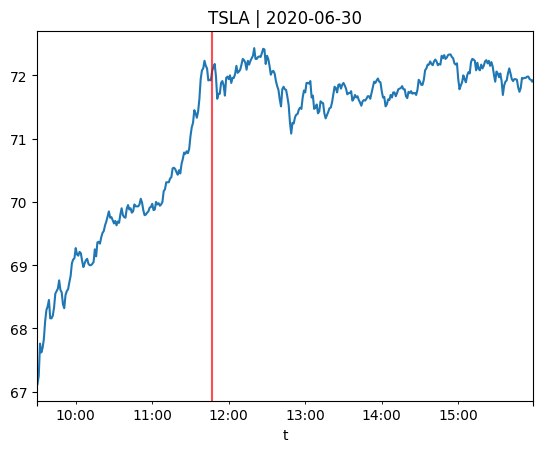

ticker: NFLX
ts: 2022-07-19 12:43:24-04:00
headline: Unprecedented Numbers Of Residential Homebuyers Bailing On Offers
score: -2.03533763472742


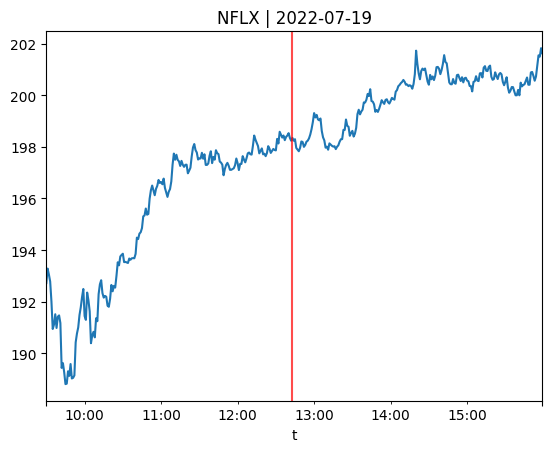

ticker: UBER
ts: 2023-03-07 11:10:13-05:00
headline: New York City Revises Proposed Min Pay For Delivery Workers; Cuts Proposed Min Delivery Worker Pay By 2025 To $19.96; Earlier Proposed Min Delivery Worker Pay By 2025 To Be $23.82
score: -3.0676511682556296


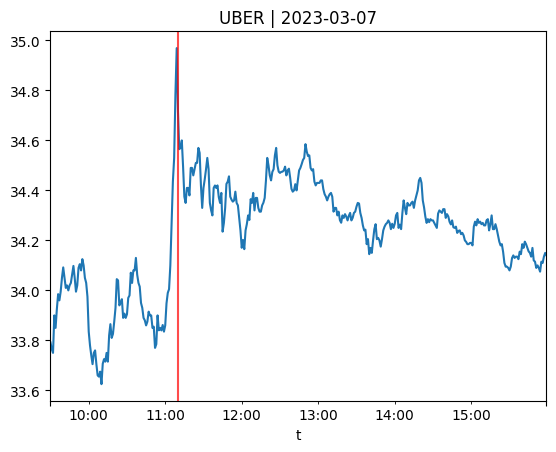

ticker: MSFT
ts: 2020-06-22 14:35:54-04:00
headline: UPDATE: Microsoft's Xbox To Partner With Facebook To Enable Mixer Community To Transition To Facebook Gaming
score: -2.1339668813892203


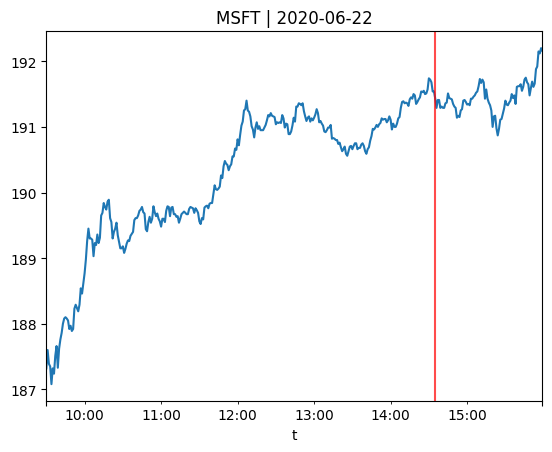

ticker: NVDA
ts: 2025-04-01 11:24:26-04:00
headline: Intel Faces Make-Or-Break Moment: Can New CEO Lip-Bu Tan Turn It Around?
score: -2.1814676128428307


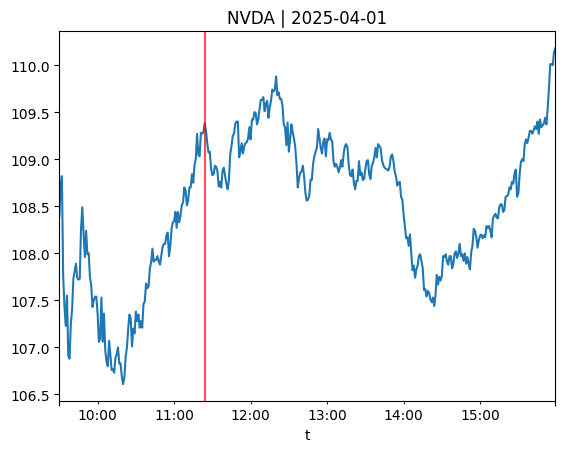

ticker: AAPL
ts: 2023-10-13 15:14:11-04:00
headline: End Of An Era: Best Buy Bids Farewell to DVDs Following Footsteps Of Netflix
score: -2.1044387244759193


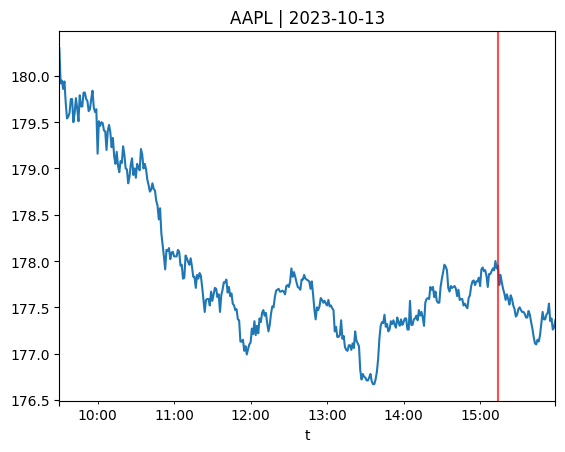

ticker: SNOW
ts: 2020-12-03 13:07:29-05:00
headline: 11 Technology Stocks Moving In Thursday's Intraday Session
score: -3.775746523185957


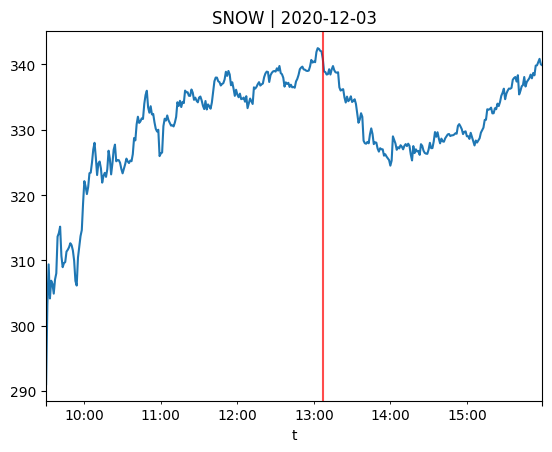

ticker: AMD
ts: 2021-12-27 14:05:07-05:00
headline: Top 10 WallStreetBets Mentions for December 27, 2021 Since 9:30 AM Open: TSLA, GME, AMZN, NVDA, AMD, AAPL, PLTR, NIO, MSFT, BABA
score: -2.4531026134201945


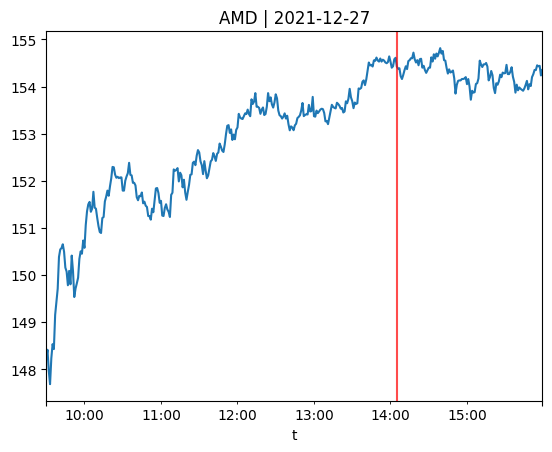

ticker: PLTR
ts: 2023-06-26 09:47:44-04:00
headline: Palantir Technologies Option Alert: Jan 19 $20 Calls Sweep (3) near the Ask: 250 @ $1.39 vs 69452 OI; Earnings 8/7 Before Open [est] Ref=$14.31
score: -2.049397250971766


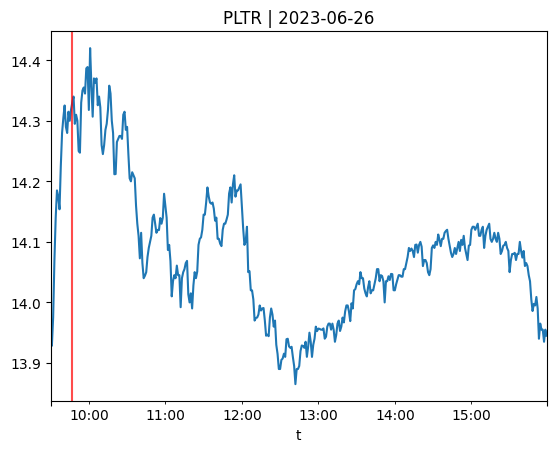

ticker: GOOGL
ts: 2022-02-03 14:31:17-05:00
headline: Is Elon Musk Responsible For The 40% Surge In Austin Home Values?
score: -2.9275563727950527


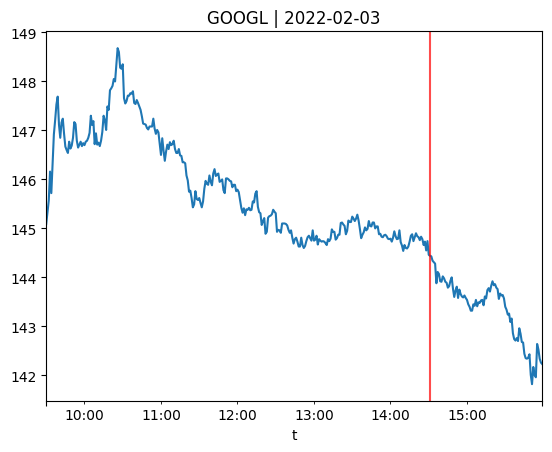

ticker: UPS
ts: 2024-03-28 12:01:35-04:00
headline: UPS Unveils Ambitious Growth Strategy at 2024 Investor Day, Targets $114 Billion Revenue by 2026 Amid Market Reset
score: -2.1903708368159873


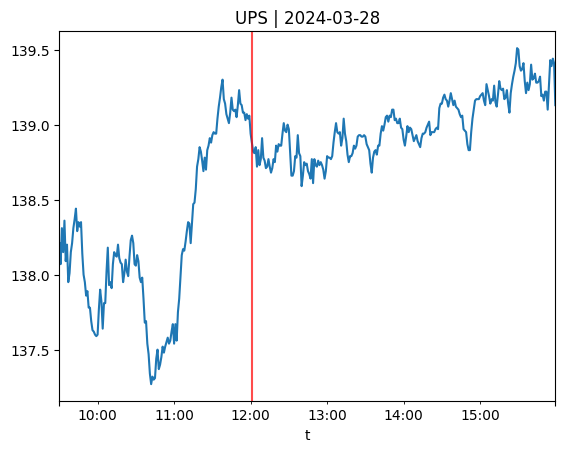

In [19]:
for _,row in lo.iterrows():
    print_row(row)

We can also look at the very top ten and the very bottom ten:

In [20]:
hi = articles_df.sort_values('impact',ascending=False).iloc[0:15]
lo = articles_df.sort_values('impact',ascending=True).iloc[0:15]


ticker: INTC
ts: 2020-12-29 12:27:58-05:00
headline: Intel Shares Spike To Session High Amid Report Dan Loeb's Third Point Has Called On Co. Mgmt. To Explore Strategic Alternatives
score: 78.1307295820559


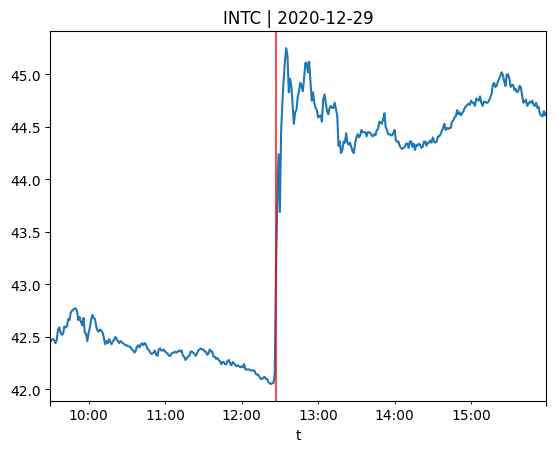

ticker: DELL
ts: 2023-06-01 15:15:27-04:00
headline: Dell Technologies Shares Resume Trade
score: 63.99169018760552


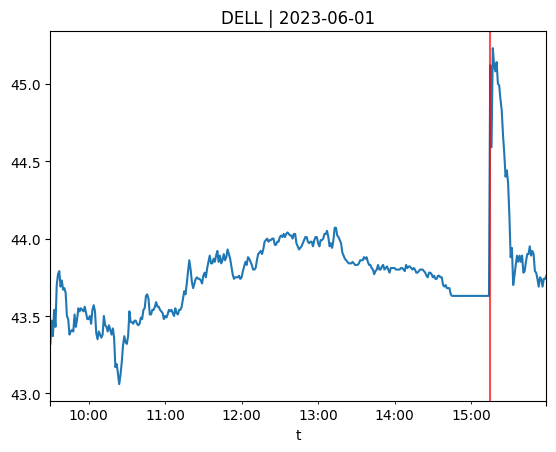

ticker: JPM
ts: 2024-12-10 12:34:22-05:00
headline: JP Morgan's Consumer CEO Lake Expects To See Modest Deposit Growth In 2025; Does Not Expect Strong Recovery In Mortgage Markets; Losses In Cards Have Been Within Expectations
score: 31.6518116902239


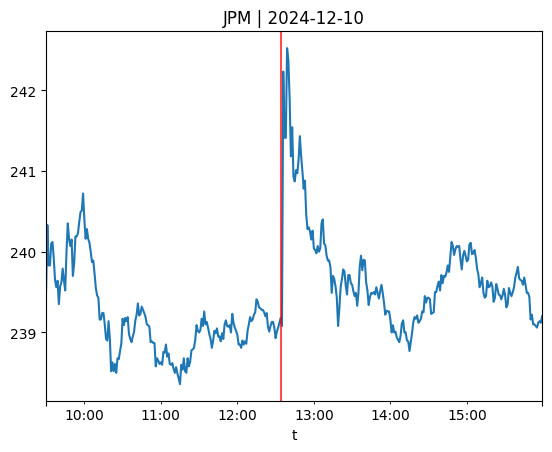

ticker: NFLX
ts: 2020-10-29 15:01:14-04:00
headline: 'Netflix is increasing its most popular plan to $14 today, premium tier increasing to $18' -The Verge Report
score: 30.244129338584482


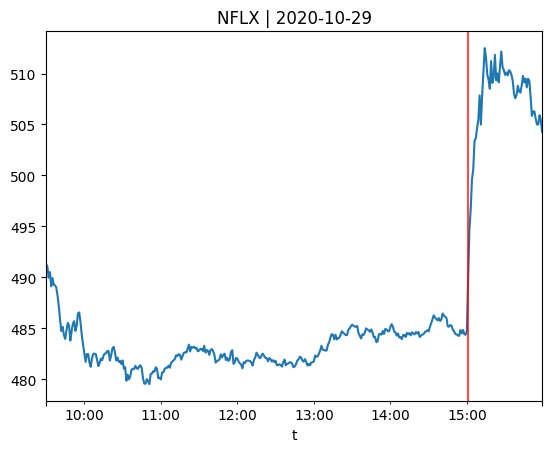

ticker: DIS
ts: 2024-08-06 13:00:49-04:00
headline: Disney Raises Streaming Prices By Up To 25% And Adds Channels; Announces Price Increases In Emailed Statement
score: 27.524830041011764


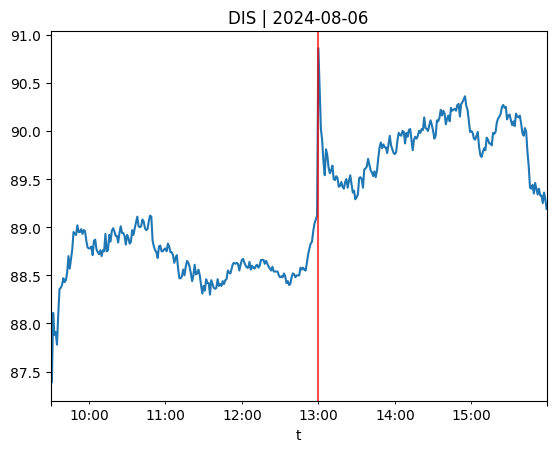

ticker: FDX
ts: 2022-09-22 14:31:29-04:00
headline: FedEx Q1 GAAP EPS $3.33
score: 22.679567586990196


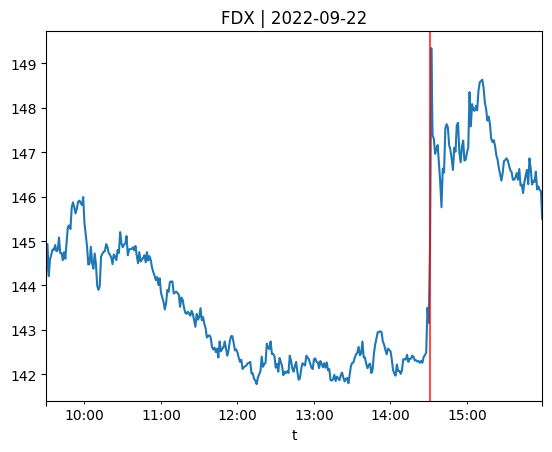

ticker: SPOT
ts: 2020-05-19 14:34:27-04:00
headline: Spotify Shares Appear Unaffected Following The Verge Article 'Joe Rogan's podcast is becoming a Spotify exclusive'
score: 22.65632298074717


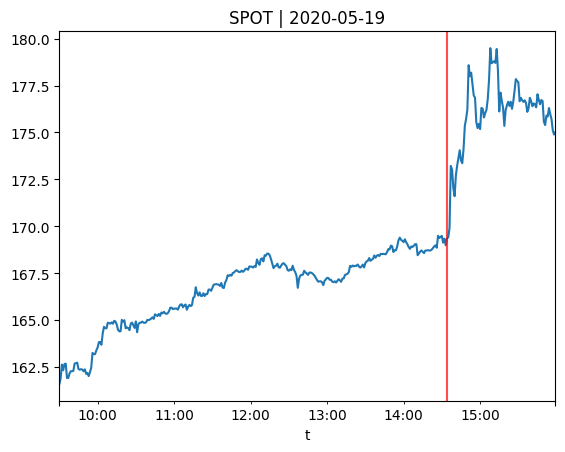

ticker: BA
ts: 2020-01-24 14:34:17-05:00
headline: PreMarket Prep Recap: Intel's Big Beat And Simple Technical Analysis At Work In Boeing
score: 22.321875556155753


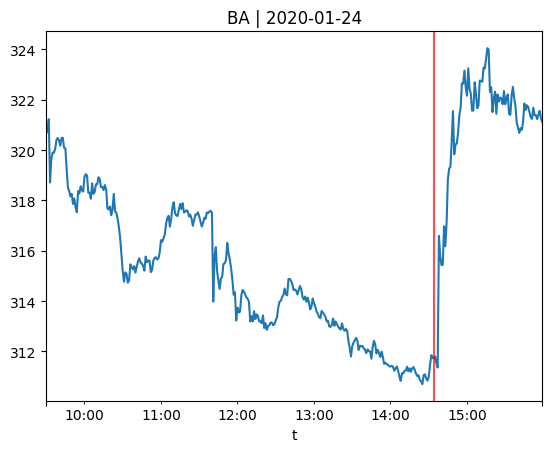

ticker: CMCSA
ts: 2020-09-21 15:49:43-04:00
headline: Nelson Peltz's Trian Takes Stake In Comcast
score: 22.15867764660509


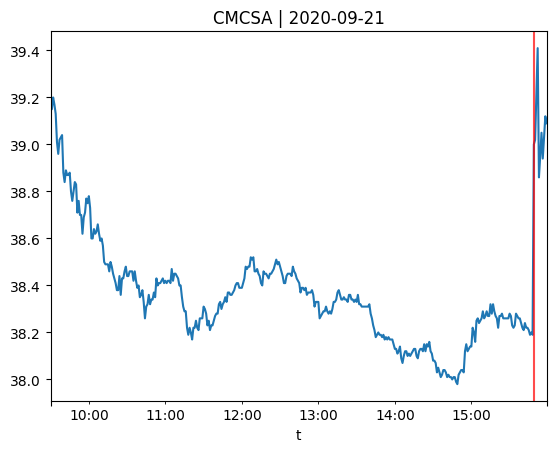

ticker: BIIB
ts: 2021-11-02 14:35:35-04:00
headline: Biogen Shares Move Higher; Traders Circulate BlueCrossBlueShield Posting SHowing Co's Aduhelm Considered 'Medically Necessary' For Treatment Of Alzheimers
score: 21.421435041198503


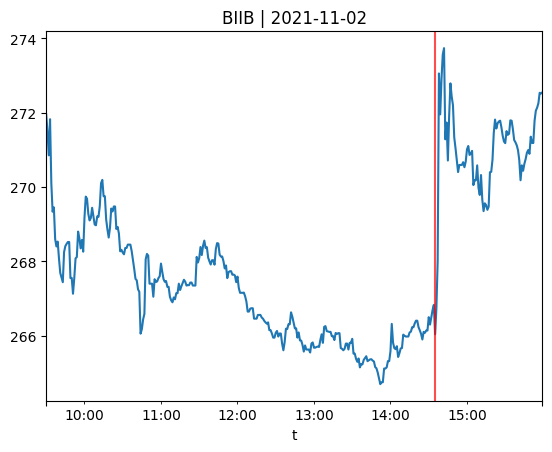

ticker: BB
ts: 2021-01-22 12:45:45-05:00
headline: BlackBerry Shares Rebound From Recent Low Near $12.30 Over Last Few Mins., Up ~2.4%; Stock Has Been Another Favorite By The Reddit Community On Wall Street Bets
score: 19.967624323956464


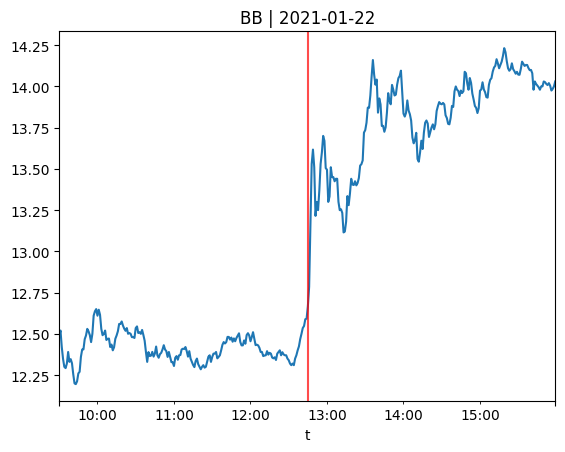

ticker: GM
ts: 2023-10-25 13:24:37-04:00
headline: Mizuho Maintains Neutral on General Motors, Lowers Price Target to $38
score: 19.097057585320353


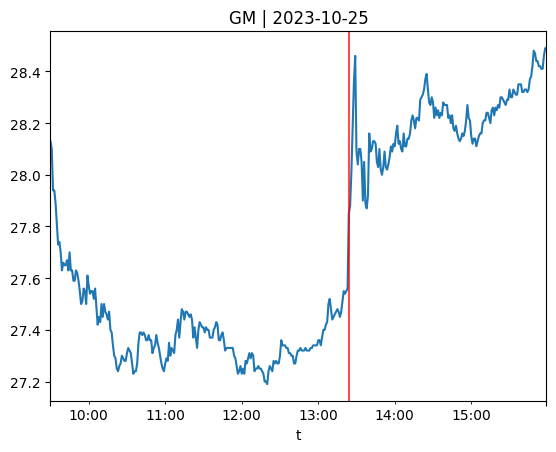

ticker: DIS
ts: 2023-06-05 14:40:38-04:00
headline: Tim Cook Introduces Disney CEO Bob Iger At WWDC 2023
score: 18.71128983198734


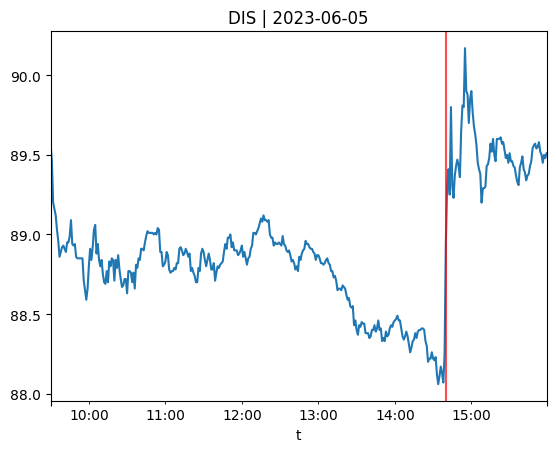

ticker: CRWD
ts: 2024-09-18 13:56:36-04:00
headline: DA Davidson Maintains Buy on CrowdStrike Holdings, Maintains $310 Price Target
score: 18.532071541724665


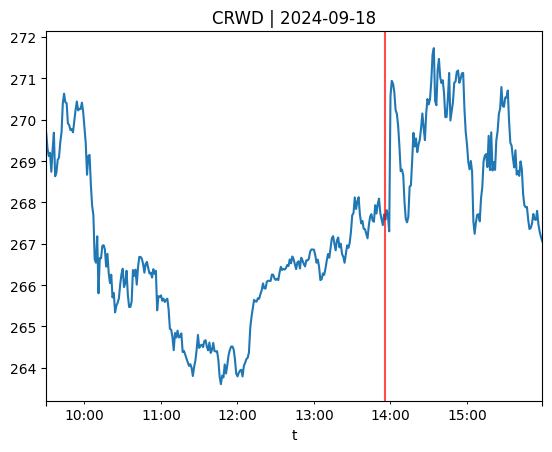

ticker: CHWY
ts: 2024-06-27 13:01:49-04:00
headline: Watching Shares Of Chewy, GameStop; Roaring Kitty Post On X A Picture Of A Dog
score: 18.420563623381323


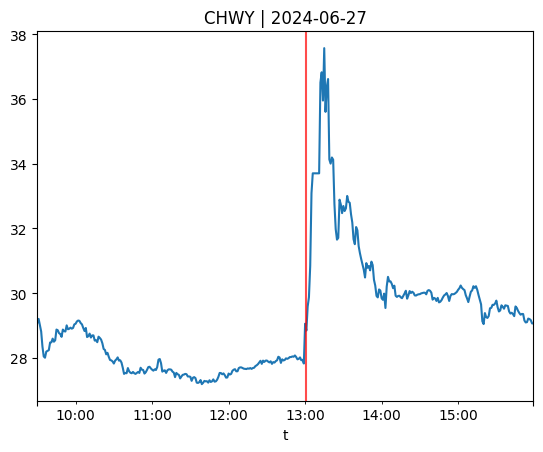

In [21]:
for _,row in hi.iterrows():
    print_row(row)

ticker: REGN
ts: 2023-06-27 15:15:17-04:00
headline: Regeneron Pharmaceuticals Shares Resume Trade Following News Halt
score: -371.8308054717003


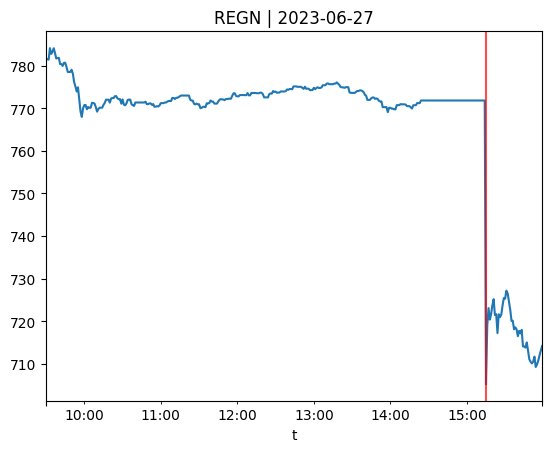

ticker: CMCSA
ts: 2021-06-23 14:48:48-04:00
headline: ViacomCBS, Roku Shares Tick Higher Following Dow Jones Article Mentioning Comcast CEO 'doesn't feel a need to seek a merger. But he is scoping out options...including a potential tie-up with ViacomCBS or an acquisition of Roku'
score: -54.59672953447296


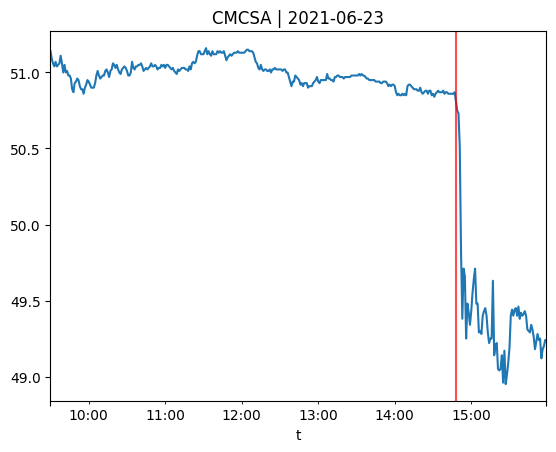

ticker: MS
ts: 2024-04-11 14:06:46-04:00
headline: Will Main Street Banks Outshine Wall Street In Q1 2024 Earnings?
score: -43.35235787887794


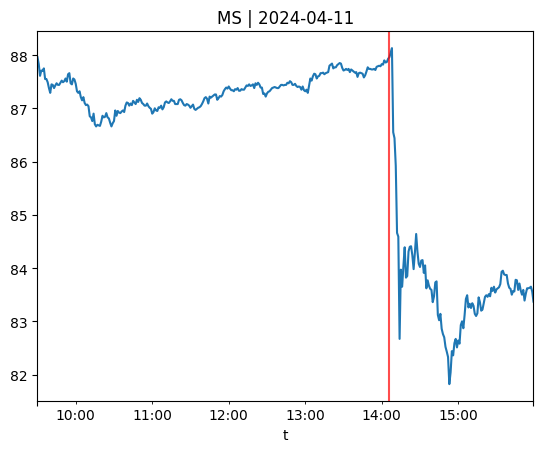

ticker: CVS
ts: 2024-01-08 10:52:31-05:00
headline: CVS Health Exec Says Co Expects To Improve Medicare Margins Beginning In 2025, And Add Up To 3%-4% In 2025 To Adjusted EPS Growth
score: -34.14721642449315


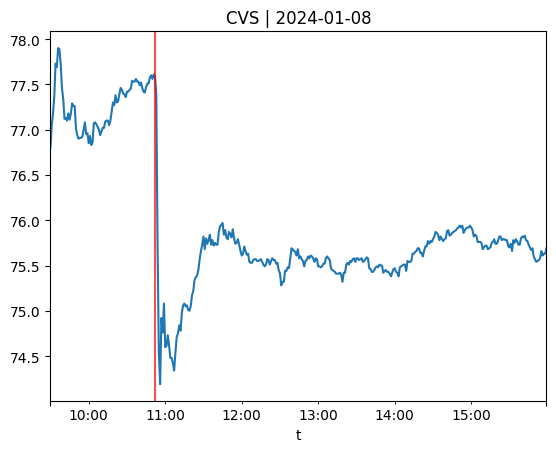

ticker: UBER
ts: 2024-06-10 12:42:04-04:00
headline: Uber Loses Appeal To Overturn California's Gig Worker Status Law
score: -30.29122537555698


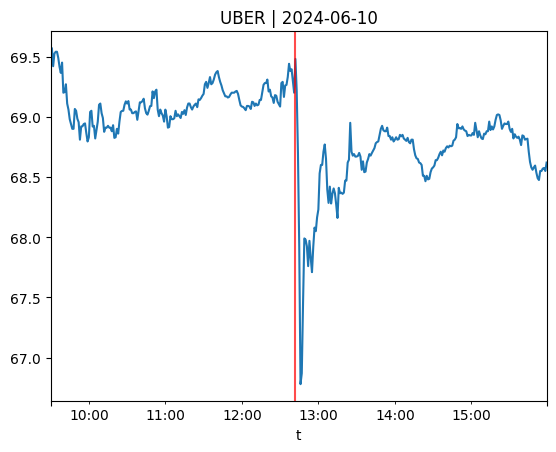

ticker: WFC
ts: 2024-09-12 14:04:29-04:00
headline: Office Of The Comptroller Of The Currency Issues Enforcement Action Vs Wells Fargo Bank
score: -28.351719985126433


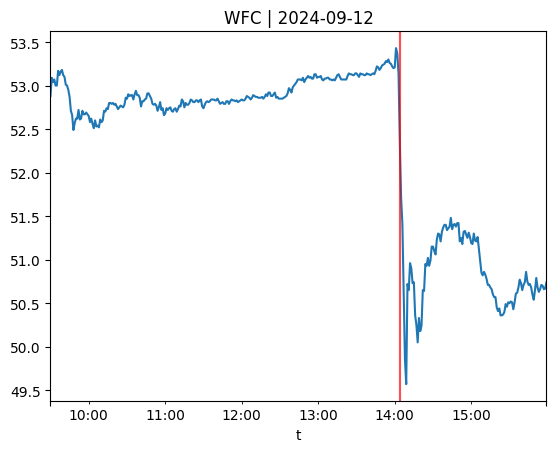

ticker: V
ts: 2024-10-29 14:47:02-04:00
headline: 'Visa Plans To Lay Off Around 1,400 Employees And Contractors; The Payments Giant Is Restructuring Its International Business' - WSJ
score: -21.529676371574517


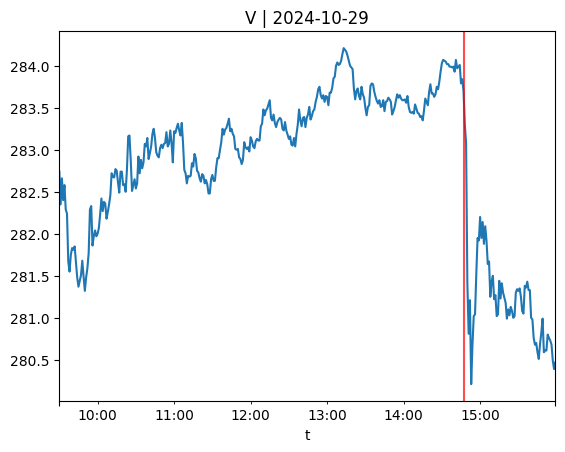

ticker: MRNA
ts: 2020-07-02 12:53:46-04:00
headline: 'A 30,000-patient trial of Moderna's coronavirus vaccine candidate, expected to start next week, has been delayed, investigators say, while stressing a start later in the month is still possible. ' -STAT News Report
score: -21.374906088295113


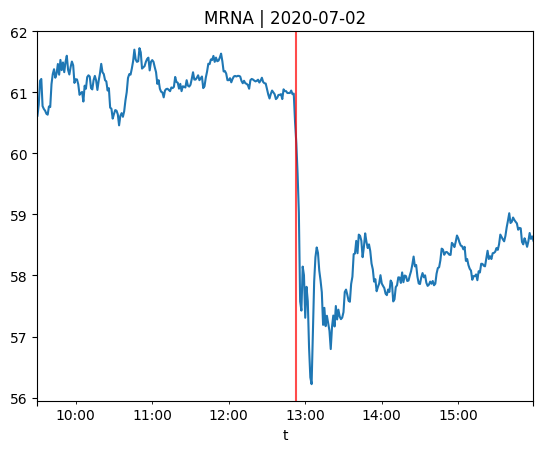

ticker: BA
ts: 2022-05-13 12:45:25-04:00
headline: US Federal Aviation Admin. Has Told Boeing Certification Docs For Co.'s 787 Dreamliner Are Incomplete
score: -20.442690035635387


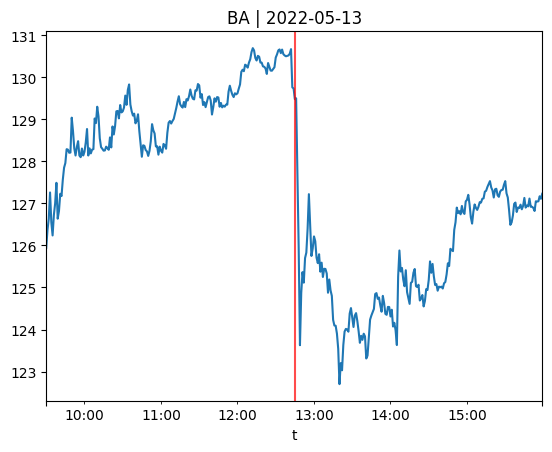

ticker: BA
ts: 2022-05-13 12:45:48-04:00
headline: UPDATE: Too Early To Say Whether FAA Concerns Over Boeing's 787 Docs Will Lead To Further Delays
score: -20.442690035635387


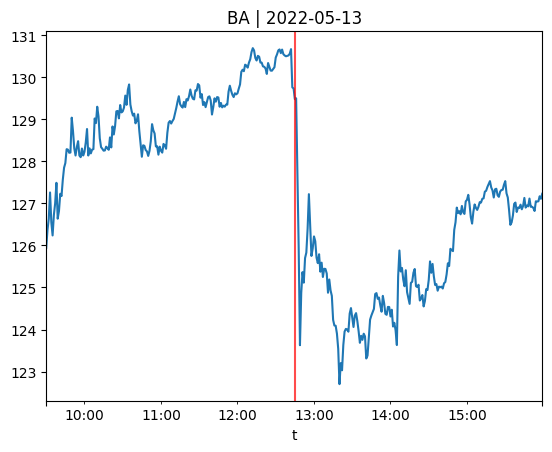

ticker: ABBV
ts: 2024-09-10 12:22:36-04:00
headline: Unitedhealth Says It Will Remove Abbvie's Humira From Some U.S. Drug Reimbursement Lists Next Year
score: -20.132672589791667


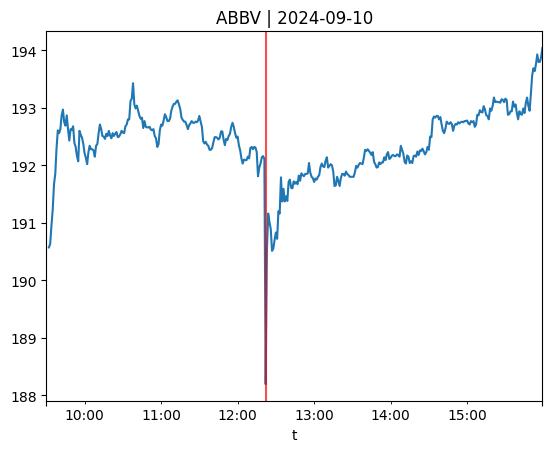

ticker: INTC
ts: 2021-04-12 12:15:17-04:00
headline: Huawei Targets Over $1B On Self-Driving, EV Technologies R&D, Amid Claims Of Beating Tesla: Bloomberg
score: -18.46686747180708


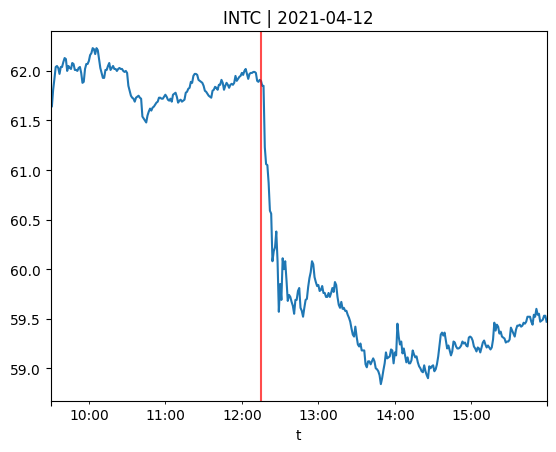

ticker: PLTR
ts: 2021-08-25 13:04:24-04:00
headline: 'FBI Palantir glitch allowed unauthorized access to private data' -New York Post Report
score: -18.449801885693


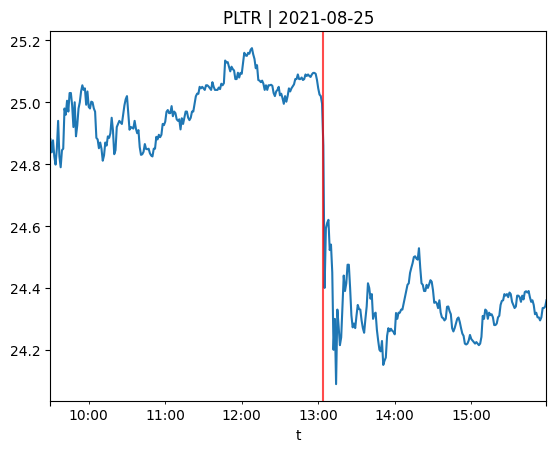

ticker: AMGN
ts: 2025-06-23 14:33:59-04:00
headline: Amgen Announces Full Results From Part 1 Of Phase 2 Study Of MariTide; Presents Complete Results From Primary Analysis Of Phase 1 PK-LDI Study Evaluating Lower Starting Doses Of MariTide At ADA 85th Scientific Sessions
score: -17.605988583818068


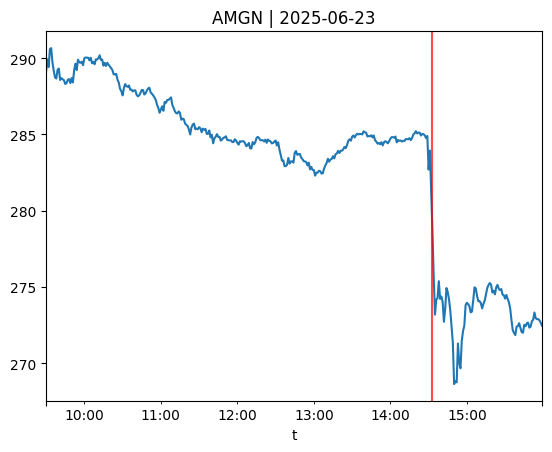

ticker: JNJ
ts: 2021-07-12 13:41:40-04:00
headline: FDA Expected To Announce New Warning On Johnson & Johnson Coronavirus Vaccine Related To Autoimmune Disorder
score: -16.25720979721801


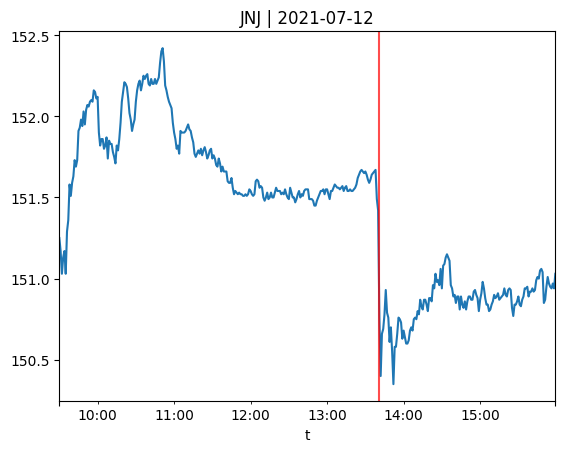

In [22]:
for _,row in lo.iterrows():
    print_row(row)

Overall, it seems that impactful articles have been identified, but there is some noise (in large part due to the number of non event-driven articles present in the dataset).